# Logistic Regression Baseline Model

## Описание модели

**Logistic Regression** — статистическая модель, использующая логистическую функцию для моделирования бинарной зависимой переменной.

### Плюсы:
- Простая и интерпретируемая
- Быстрое обучение и предсказание
- Хорошо работает для линейно разделимых данных

### Минусы:
- Не подходит для сложных зависимостей в данных
- Не может улавливать нелинейные паттерны

### Библиотеки:
- scikit-learn, LogisticRegression


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [ ]:
# Загрузка предобработанных данных
current_dir = Path.cwd()
file_path = current_dir.parent / "data" / "data_remapped.csv"
train_df = pd.read_csv(file_path, index_col=0)

if 'Unnamed: 0' in train_df.columns:
    train_df = train_df.drop('Unnamed: 0', axis=1)

print(f"Размер датасета: {train_df.shape}")
print(f"\nПервые строки:")
train_df.head()


Размер датасета: (7905, 19)

Первые строки:


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_encoded,Sex_encoded,Ascites_encoded,Hepatomegaly_encoded,Spiders_encoded,Edema_encoded,Status_encoded
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,1,1,0,0,0,0,0
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,0,0,0,0,0,1
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,0,0,0,1,1,1,0
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,0,0,0,0,0,1
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,0,0,1,0,0,1


## Анализ целевой переменной

Проверим распределение классов в целевой переменной `Status_encoded`:
- 0 - D (Dead, умер)
- 1 - C (Censored, жив)
- 2 - CL (Censored due to liver transplantation, жив вследствие трансплантации печени)


Распределение классов в целевом признаке Status_encoded:
Status_encoded
0    2665
1    4965
2     275
Name: count, dtype: int64

Процентное распределение:
Status_encoded
0    33.712840
1    62.808349
2     3.478811
Name: proportion, dtype: float64


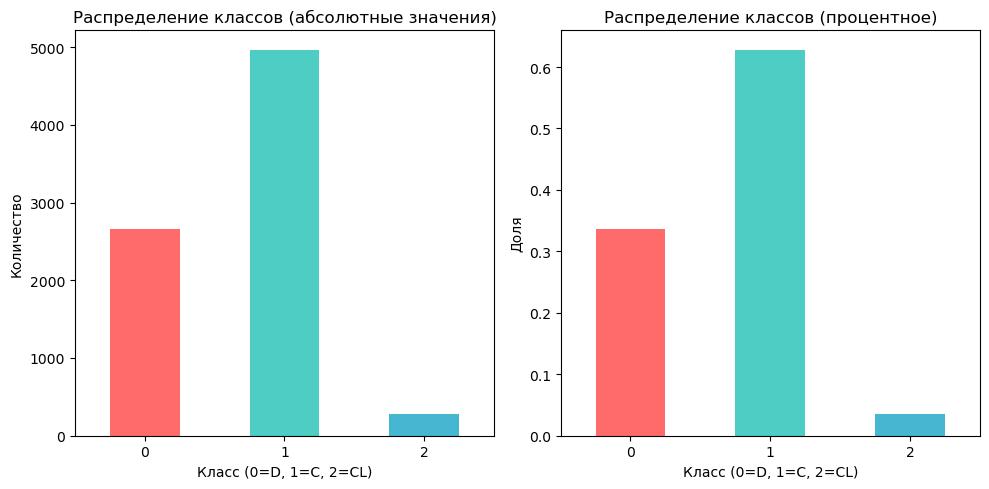

In [ ]:
print("Распределение классов в целевом признаке Status_encoded:")
print(train_df['Status_encoded'].value_counts().sort_index())
print("\nПроцентное распределение:")
print(train_df['Status_encoded'].value_counts(normalize=True).sort_index() * 100)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train_df['Status_encoded'].value_counts().sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Распределение классов (абсолютные значения)')
plt.xlabel('Класс (0=D, 1=C, 2=CL)')
plt.ylabel('Количество')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
train_df['Status_encoded'].value_counts(normalize=True).sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Распределение классов (процентное)')
plt.xlabel('Класс (0=D, 1=C, 2=CL)')
plt.ylabel('Доля')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


## Разделение на обучающую и тестовую выборки

Используем стратифицированное разбиение для сохранения пропорций классов в обеих выборках.


In [ ]:
X = train_df.drop("Status_encoded", axis=1)
y = train_df["Status_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=8, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True).sort_index() * 100)

print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True).sort_index() * 100)


Размер обучающей выборки: (6324, 18)
Размер тестовой выборки: (1581, 18)

Распределение классов в обучающей выборке:
Status_encoded
0    33.712840
1    62.808349
2     3.478811
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Status_encoded
0    33.712840
1    62.808349
2     3.478811
Name: proportion, dtype: float64


## Масштабирование признаков

Для логистической регрессии важно масштабировать признаки, так как модель чувствительна к масштабу данных.


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Масштабирование выполнено успешно!")
print(f"Средние значения признаков (после масштабирования):\n{X_train_scaled.mean().head()}")
print(f"\nСтандартные отклонения (после масштабирования):\n{X_train_scaled.std().head()}")


Масштабирование выполнено успешно!
Средние значения признаков (после масштабирования):
N_Days         2.528022e-18
Age            1.550520e-16
Bilirubin     -7.415531e-17
Cholesterol   -8.988523e-18
Albumin        9.775019e-16
dtype: float64

Стандартные отклонения (после масштабирования):
N_Days         1.000079
Age            1.000079
Bilirubin      1.000079
Cholesterol    1.000079
Albumin        1.000079
dtype: float64


## Обучение модели логистической регрессии

Создаем baseline модель с параметрами по умолчанию и проводим кросс-валидацию.


In [37]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)

model = LogisticRegression(C=1, max_iter=1000, random_state=8, multi_class='multinomial', solver='lbfgs')

scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='neg_log_loss')

print("Log loss scores for each fold:", scores * -1)
print(f"\nAverage log loss: {scores.mean() * -1:.4f}")
print(f"Standard deviation: {scores.std() * -1:.4f}")


Log loss scores for each fold: [0.55432903 0.54087908 0.55592406 0.52830518 0.52354544 0.5159216
 0.56404322 0.53646579 0.53065928 0.49233824]

Average log loss: 0.5342
Standard deviation: -0.0202


Обучим модель на всей обучающей выборке

In [25]:
model.fit(X_train_scaled, y_train)

print(f"Количество итераций: {model.n_iter_[0]}")


Количество итераций: 16


Оценим качество модели на тестовой выборке

In [26]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

test_log_loss = log_loss(y_test, y_pred_proba)
print(f"Log Loss на тестовой выборке: {test_log_loss:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['D (Dead)', 'C (Censored)', 'CL (Transplant)']))


Log Loss на тестовой выборке: 0.5104
Classification Report:
                 precision    recall  f1-score   support

       D (Dead)       0.76      0.68      0.72       533
   C (Censored)       0.82      0.91      0.86       993
CL (Transplant)       0.00      0.00      0.00        55

       accuracy                           0.80      1581
      macro avg       0.52      0.53      0.52      1581
   weighted avg       0.77      0.80      0.78      1581



Визуализируем матрицу ошибок для анализа качества классификации по каждому классу.

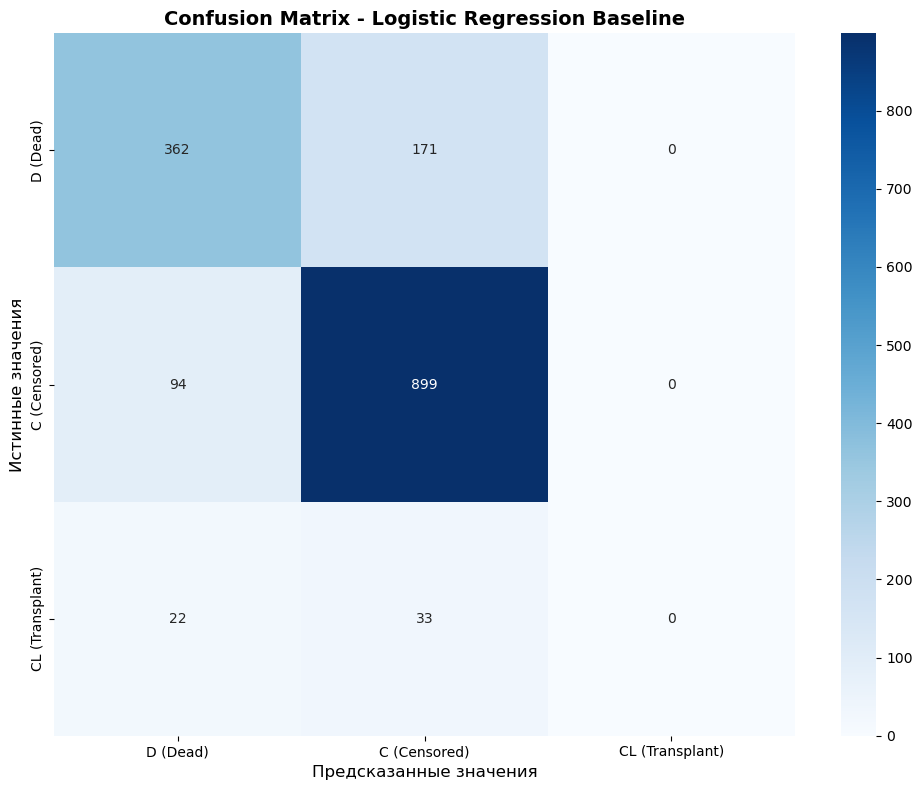

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['D (Dead)', 'C (Censored)', 'CL (Transplant)'],
            yticklabels=['D (Dead)', 'C (Censored)', 'CL (Transplant)'])
plt.title('Confusion Matrix - Logistic Regression Baseline', fontsize=14, fontweight='bold')
plt.ylabel('Истинные значения', fontsize=12)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.tight_layout()
plt.show()


Посмотрим на коэффициенты модели для понимания важности признаков.

Топ-10 наиболее важных признаков:
                       Abs_Sum
Age                   0.843619
N_Days                0.640565
Prothrombin           0.637660
Bilirubin             0.571201
Stage                 0.451346
Copper                0.434212
SGOT                  0.374723
Hepatomegaly_encoded  0.271083
Platelets             0.258699
Spiders_encoded       0.255993


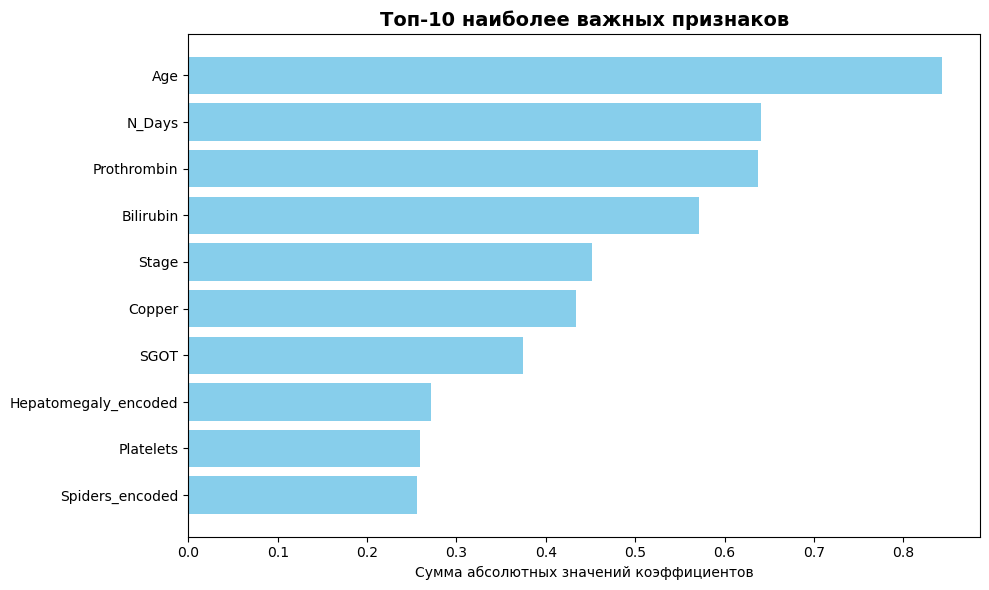

In [ ]:
feature_importance = pd.DataFrame(
    model.coef_,
    columns=X_train.columns,
    index=['Class 0 (D)', 'Class 1 (C)', 'Class 2 (CL)']
).T

feature_importance['Abs_Sum'] = feature_importance.abs().sum(axis=1)
feature_importance = feature_importance.sort_values('Abs_Sum', ascending=False)

print("Топ-10 наиболее важных признаков:")
print(feature_importance[['Abs_Sum']].head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Abs_Sum'], color='skyblue')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Сумма абсолютных значений коэффициентов')
plt.title('Топ-10 наиболее важных признаков', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

## Бинарная классификация (класс D и класс C)

Теперь обучим модель логистической регрессии только на двух классах: D (Dead) и C (Censored), исключив класс CL (Transplant)


Размер датасета для бинарной классификации: (7630, 19)

Распределение классов:
Status_encoded
0    2665
1    4965
Name: count, dtype: int64

Процентное распределение:
Status_encoded
0    34.927916
1    65.072084
Name: proportion, dtype: float64


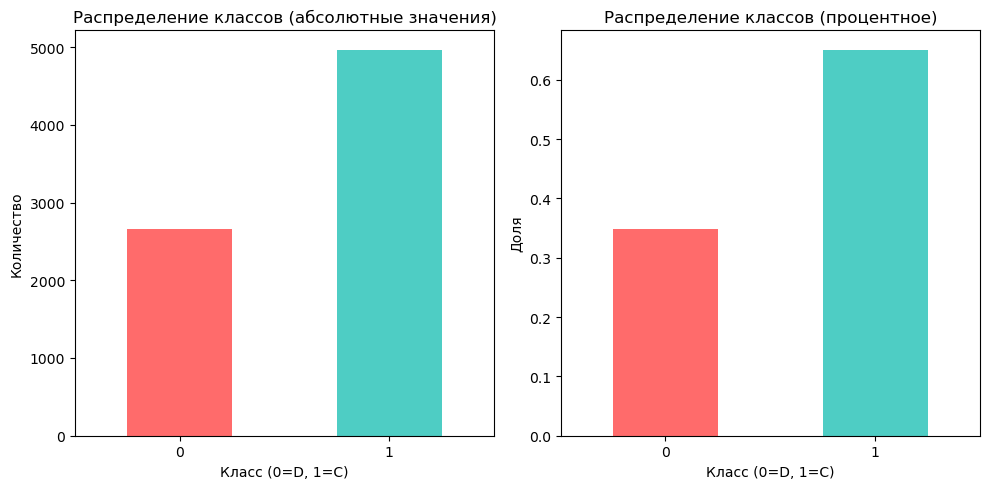

In [ ]:
# Оставляем только два класса
binary_mask = train_df['Status_encoded'].isin([0, 1])
train_df_binary = train_df[binary_mask].copy()

print(f"Размер датасета для бинарной классификации: {train_df_binary.shape}")
print(f"\nРаспределение классов:")
print(train_df_binary['Status_encoded'].value_counts().sort_index())
print("\nПроцентное распределение:")
print(train_df_binary['Status_encoded'].value_counts(normalize=True).sort_index() * 100)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train_df_binary['Status_encoded'].value_counts().sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.title('Распределение классов (абсолютные значения)')
plt.xlabel('Класс (0=D, 1=C)')
plt.ylabel('Количество')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
train_df_binary['Status_encoded'].value_counts(normalize=True).sort_index().plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.title('Распределение классов (процентное)')
plt.xlabel('Класс (0=D, 1=C)')
plt.ylabel('Доля')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [28]:
X_binary = train_df_binary.drop("Status_encoded", axis=1)
y_binary = train_df_binary["Status_encoded"]

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=8, stratify=y_binary
)

print(f"Размер обучающей выборки: {X_train_binary.shape}")
print(f"Размер тестовой выборки: {X_test_binary.shape}")


Размер обучающей выборки: (6104, 18)
Размер тестовой выборки: (1526, 18)


In [30]:
# Масштабирование признаков
scaler_binary = StandardScaler()
X_train_binary_scaled = scaler_binary.fit_transform(X_train_binary)
X_test_binary_scaled = scaler_binary.transform(X_test_binary)

X_train_binary_scaled = pd.DataFrame(X_train_binary_scaled, columns=X_train_binary.columns, index=X_train_binary.index)
X_test_binary_scaled = pd.DataFrame(X_test_binary_scaled, columns=X_test_binary.columns, index=X_test_binary.index)


### Обучение модели логистической регрессии

In [ ]:
kfold_binary = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)

model_binary = LogisticRegression(C=1, max_iter=1000, random_state=8)

scores_binary = cross_val_score(model_binary, X_train_binary_scaled, y_train_binary, 
                                cv=kfold_binary, scoring='neg_log_loss')

print("Log loss для каждого фолда:", scores_binary * -1)
print(f"\nУстредненная log loss: {scores_binary.mean() * -1:.4f}")
print(f"Стандартное отклонение: {scores_binary.std() * -1:.4f}")


Log loss для каждого фолда: [0.39492567 0.43365651 0.41439523 0.39964823 0.38721412 0.41034913
 0.41729113 0.39827519 0.43563593 0.42302359]

Устредненная log loss: 0.4114
Стандартное отклонение: -0.0156


Обучим модель на всей обучающей выборке

In [33]:
model_binary.fit(X_train_binary_scaled, y_train_binary)

print(f"Количество итераций: {model_binary.n_iter_[0]}")


Количество итераций: 9


Оценим качество модели на тестовой выборке

In [38]:
y_pred_binary = model_binary.predict(X_test_binary_scaled)
y_pred_proba_binary = model_binary.predict_proba(X_test_binary_scaled)

test_log_loss_binary = log_loss(y_test_binary, y_pred_proba_binary)
print(f"Log Loss на тестовой выборке: {test_log_loss_binary:.4f}")

print("Classification Report (Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, 
                          target_names=['D (Dead)', 'C (Censored)']))


Log Loss на тестовой выборке: 0.3902
Classification Report (Binary Classification):
              precision    recall  f1-score   support

    D (Dead)       0.79      0.68      0.73       533
C (Censored)       0.84      0.91      0.87       993

    accuracy                           0.83      1526
   macro avg       0.82      0.79      0.80      1526
weighted avg       0.82      0.83      0.82      1526



Визуализируем матрицу ошибок для анализа качества классификации по каждому классу.

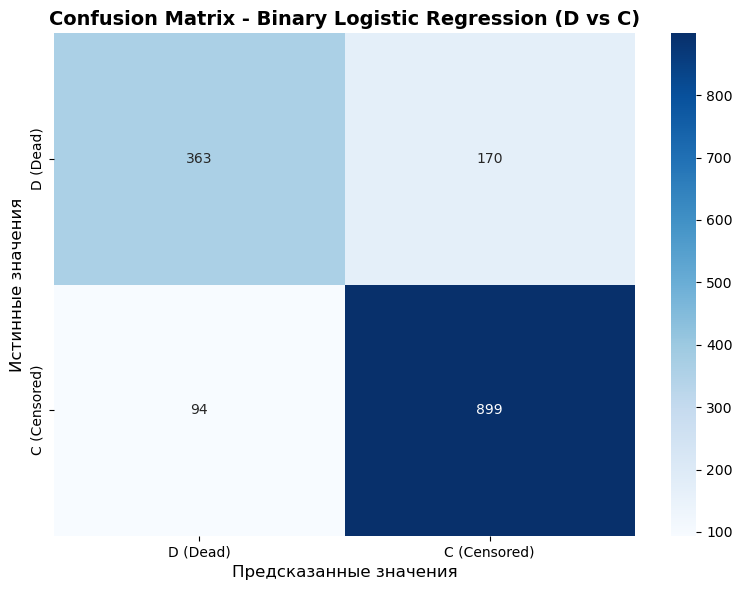

In [35]:
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['D (Dead)', 'C (Censored)'],
            yticklabels=['D (Dead)', 'C (Censored)'])
plt.title('Confusion Matrix - Binary Logistic Regression (D vs C)', fontsize=14, fontweight='bold')
plt.ylabel('Истинные значения', fontsize=12)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.tight_layout()
plt.show()


Посмотрим на коэффициенты модели для понимания важности признаков.

Топ-10 наиболее важных признаков:
                      Coefficient  Abs_Coefficient
Prothrombin             -0.530248         0.530248
Bilirubin               -0.517474         0.517474
Stage                   -0.390676         0.390676
SGOT                    -0.330693         0.330693
Copper                  -0.301087         0.301087
Hepatomegaly_encoded    -0.256802         0.256802
N_Days                   0.253525         0.253525
Age                     -0.227448         0.227448
Spiders_encoded         -0.207088         0.207088
Sex_encoded             -0.179802         0.179802


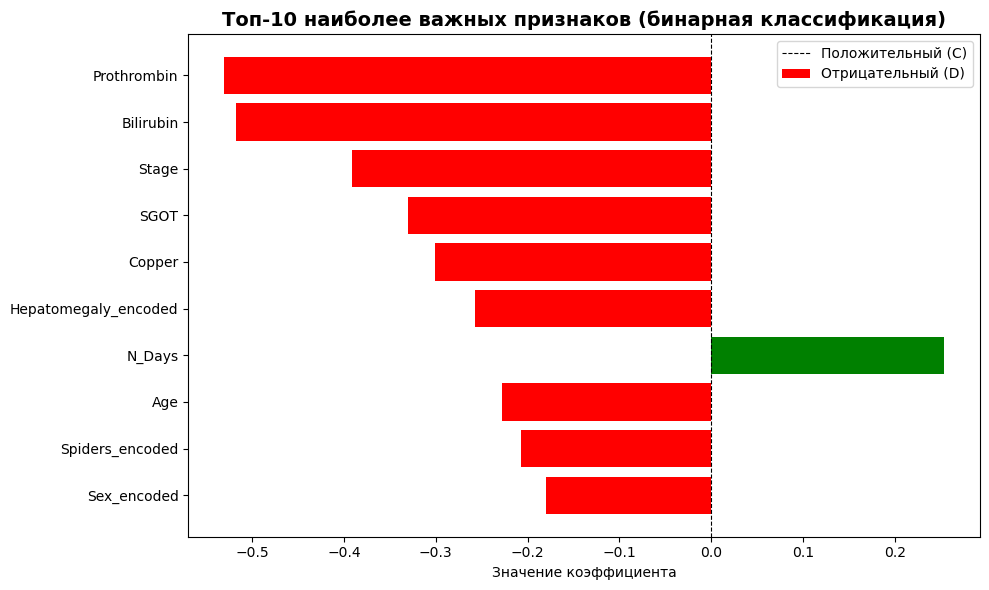

In [23]:
feature_importance_binary = pd.DataFrame(
    {'Coefficient': model_binary.coef_[0]},
    index=X_train_binary.columns
)

feature_importance_binary['Abs_Coefficient'] = feature_importance_binary['Coefficient'].abs()
feature_importance_binary = feature_importance_binary.sort_values('Abs_Coefficient', ascending=False)

print("Топ-10 наиболее важных признаков:")
print(feature_importance_binary[['Coefficient', 'Abs_Coefficient']].head(10))

plt.figure(figsize=(10, 6))
top_features_binary = feature_importance_binary.head(10)
colors = ['red' if x < 0 else 'green' for x in top_features_binary['Coefficient']]
plt.barh(range(len(top_features_binary)), top_features_binary['Coefficient'], color=colors)
plt.yticks(range(len(top_features_binary)), top_features_binary.index)
plt.xlabel('Значение коэффициента')
plt.title('Топ-10 наиболее важных признаков (бинарная классификация)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.legend(['Положительный (C)', 'Отрицательный (D)'], loc='best')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


- Положительные коэффициенты увеличивают вероятность класса C (Censored)
- Отрицательные коэффициенты увеличивают вероятность класса D (Dead)